# **Discovering Stop-Antistop Quark Pair Production ($\tilde{t},\tilde{\bar{t}}$) with ATLAS Open Data**
This notebook will guide you through a hands-on analysis of high-energy proton-proton collision data from the ATLAS experiment at the Large Hadron Collider (LHC), focusing on the search for supersymmetric top quark partners: the **stop ($\tilde{t}$)** and **antistop ($\tilde{\bar{t}}$)**. These hypothetical particles are predicted by Supersymmetry (SUSY) and could provide answers to fundamental open questions in the Standard Model.

ATLAS Open Data offers publicly available datasets collected at $\sqrt{s} = 13$ TeV, ideal for educational analyses ranging from high-school to postgraduate levels. In this notebook, you will learn how to:

Understand the event topology of stop-antistop production.

Apply event selection ("cuts") to enhance the sensitivity to SUSY signals.

Use physics-motivated observables (e.g., lepton kinematics, b-tagged jets, missing transverse energy) to reduce backgrounds.

Reconstruct variables relevant to SUSY signatures and search for excesses beyond the Standard Model expectations.

# **Physics Motivation: The $\tilde{t},\tilde{\bar{t}}$ Decay Channel**
We focus on the decay chain:

$\tilde{t}\tilde{\bar{t}} → t\bar{t} + \tilde{χ}^0_1\tilde{χ}^0_1 → (bW^+)(\bar{b}W^-) + \tilde{χ}^0_1\tilde{χ}^0_1$

Assuming both $W$ bosons decay leptonically, and considering one electron and one muon in the final state, we study the following signature:

$pp → \tilde{t}\tilde{\bar{t}} → e^{±}μ^{∓}b\bar{b} + E^{miss}_T$

where:

$e^\pm$, $\mu^\mp$ are opposite-sign, different-flavor leptons,

$b$, $\bar{b}$ are b-tagged jets,

$E_T^{\text{miss}}$ represents the missing transverse energy due to undetected neutralinos ($\tilde{\chi}_1^0$).

This dileptonic channel has a relatively low Standard Model background and good sensitivity to SUSY signals.

# **The Goal: Identify a SUSY Signal in the $e\mu b\bar{b} + E_T^{\text{miss}}$ Final State**
By following this notebook, you will aim to identify an excess of events consistent with the decay of $\tilde{t},\tilde{\bar{t}}$ pairs. You will:

Select events with exactly one isolated electron and one isolated muon,

Require at least two b-tagged jets,

Study the distributions of $Δη(l^+l^-)$, $Δφ(l^+l^-)$and other variables,

Compare data with Standard Model Monte Carlo (MC) simulations to assess compatibility or deviations

# **What Are Notebooks?**

Notebooks are interactive web applications that allow you to create and share documents that contain:

1. **Live code:** Write and execute code in real-time, making adjustments as you go.

2. **Visualizations:** Create plots, histograms, and other graphical representations of your data to better understand the underlying physics.

3. **Narrative text:** Include explanations, descriptions, and commentary to guide yourself or others through the analysis.

# **Running a Jupyter notebook**
To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.


# **ATLAS Open Data Initialisation**
**First time package installation on your computer**

This first cell installs the required python packages. It only needs to be run the first time you open this notebook on your computer. If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

In [ ]:
!pip install atlasopenmagic
!pip install uproot
!pip install pyhf

# **To setup**
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us use efficiently the nested data in columnar format
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* concurrent.futures: Enables parallel execution, which speeds up computations when working with large datasets.

In [ ]:
import uproot  # For reading ROOT files efficiently
import awkward as ak  # To represent nested data in columnar format
import numpy as np  # For numerical calculations such as histogramming
import pandas as pd # For dataframes, a format widely used in python
import matplotlib.pyplot as plt  # For creating plots and visualizations
from matplotlib.ticker import AutoMinorLocator  # For adding minor ticks to plot axes
import atlasopenmagic as atom  # Provides access to ATLAS Open Data metadata and streaming URLs
from concurrent.futures import ProcessPoolExecutor, as_completed # Enables parallel execution for faster processing of large datasets
import pyhf  # Import pyhf (Python HistFactory), a statistical modeling library used for likelihood fits and hypothesis testing in HEP analyses


import time  # For timing operations and adding delays if needed
# Filter warnings that otherwise appear in output. These are normal in the running of this notebook.
import warnings

warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
warnings.filterwarnings("ignore", message="overflow encountered in power")
warnings.filterwarnings("ignore", message="overflow encountered in multiply", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")

# **Explanation of Key Parameters in the $\tilde{t}\tilde{\bar{t}}$ Analysis Code**

In particle physics analyses, various parameters and constants are essential for accurately processing data and interpreting results. Below is an explanation of the key parameters used in the
 $t\bar{t}$ analysis code provided:

1.   **Integrated Luminosity (lumi)**

  *   Definition: Integrated luminosity is a measure of the total amount of data collected by a particle detector over a certain period. It represents the total number of potential collisions that could have occurred in a particle accelerator and is typically measured in inverse femtobarns fb$^{-1}$.

2. **Fraction of Events to Process**

  *   Definition: This parameter controls what fraction of the available events in the dataset will be processed by the analysis.


3. **MV2c10 b-Tagging Algorithm Discriminant Cut Value Definition**
  * The MV2c10 is a b-tagging algorithm used to identify jets originating from b-quarks. The discriminant cut value determines the threshold for tagging a jet as a b-jet.

  For further information visit [atlas glossary](https://atlas.cern/glossary)

In [ ]:
# Integrated luminosity in inverse picobarns
lumi = 36000.

# Fraction of events to process
fraction = 0.01

# MV2c10 b-tagging algorithm discriminant cut value
MV2c10_lim = 4

# **Samples**
To study the production of stop-antistop quark pairs ($\tilde{t} \tilde{\bar{t}}$), we employ a carefully chosen set of data and Monte Carlo (MC) simulation samples. These samples capture both the potential signal from supersymmetric processes and the dominant background contributions from Standard Model (SM) processes that can mimic the expected final state.

In [ ]:
atom.set_release('2025e-13tev-beta')  # Set ATLAS Open Data release

# Data
data_defs = {
    r'Data': {'dids': ["data"]}
}

# MC (detector level)
mc_defs_1 = {
    r'ttbar': {'dids': [410470, 410471]},
    r'tW':    {'dids': [410658, 410659, 410644, 410645, 601352, 601355]},
}

# MC for systematics
mc_defs_2 = {
    r'ttbar_for_sys': {'dids': [411234]}
}

# Truth MC
mc_defs_3 = {
    r'tr_ttbar': {'dids': [410470, 410471]},
    r'tr_tW':    {'dids': [410658, 410659, 410644, 410645, 601352, 601355]},
}

# Both truth and reco MC
mc_defs_4 = {
    r'both_ttbar': {'dids': [410470, 410471]},
    r'both_tW':    {'dids': [410658, 410659, 410644, 410645, 601352, 601355]},
}

######## add SUSY ########

# Build datasets
data         = atom.build_dataset(data_defs,   skim='2J2LMET30', protocol='https',cache=True)
mc_samples_1 = atom.build_dataset(mc_defs_1,   skim='2J2LMET30', protocol='https',cache=True)
mc_samples_2 = atom.build_dataset(mc_defs_2,   skim='2J2LMET30', protocol='https',cache=True)
mc_samples_3 = atom.build_dataset(mc_defs_3,   skim='2J2LMET30', protocol='https',cache=True)
mc_samples_4 = atom.build_dataset(mc_defs_4,   skim='2J2LMET30', protocol='https',cache=True)
######## add SUSY ########

# Merge samples
samples = {**data, **mc_samples_1, **mc_samples_2, **mc_samples_3}

# Variables to load
variables = [
    "mcWeight", "ScaleFactor_LepTRIGGER", "ScaleFactor_MLTRIGGER", "trigE", "trigM",
    "lep_n", "lep_pt", "ScaleFactor_BTAG", "lep_eta", "lep_phi", "lep_charge", "lep_type",
    "met", "met_phi", "sum_of_weights", "ScaleFactor_FTAG", "xsec",
    "jet_pt", "jet_btag_quantile", "jet_n", "jet_eta", "jet_phi", "jet_e", "jet_jvt",
    "lep_isTrigMatched", "lep_type", "lep_e", "eventNumber",
    "ScaleFactor_ELE", "ScaleFactor_MUON", "ScaleFactor_PILEUP", "filteff", "kfac",
    "truth_elec_n","truth_elec_eta","truth_elec_phi","truth_elec_pt",
    "truth_muon_n","truth_muon_eta","truth_muon_phi","truth_muon_pt",
    "truth_jet_pt","truth_jet_eta","truth_jet_phi"]


Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.
Active release: 2025e-13tev-beta. Metadata cache cleared. (Datasets path: REMOTE)


# **Weight in Supersymmetric Particle Physics Analysis**
In searches for new physics phenomena, such as the production of scalar top quark pairs ($\tilde{t} \tilde{\bar{t}}$) in supersymmetric (SUSY) models, event weights are essential to accurately interpret the results of Monte Carlo (MC) simulations and compare them with real experimental data.

Each MC event represents not a single physical occurrence, but rather a probabilistic sample of a certain physical process. To ensure that the total event yield and distributions correctly reflect the expected number of events in actual data, weights are applied to each event.

In [ ]:
def calc_weight(data):
    weight_list =(  data["ScaleFactor_PILEUP"] * data["ScaleFactor_ELE"] * data["ScaleFactor_MUON"] *
                 ( data["ScaleFactor_BTAG"] * data["mcWeight"] / data["sum_of_weights"]) *
                 (data["xsec"] * data["filteff"] * data["kfac"] * lumi) )
    return weight_list

# **Introduction to Event Selection Cuts in $\tilde{t}\tilde{\bar{t}}$ Analysis**

In particle physics, particularly in the analysis of stop-antistop $\tilde{t}\tilde{\bar{t}}$ quark pair production, the process of event selection is crucial for isolating the signal from the background. The goal is to apply a series of cuts, or selection criteria, that filter out events unlikely to be associated with the $\tilde{t}\tilde{\bar{t}}$ process, leaving a dataset enriched with signal events. These cuts are based on specific physical properties of the events, such as the presence and characteristics of leptons and jets.

Each cut is designed to enhance the signal-to-background ratio, which is essential for making a clear observation of the $\tilde{t}\tilde{\bar{t}}$ signal. Below is an overview of the key cuts applied in this analysis:

1. **Trigger Selection:**
  * The first step in the analysis is to ensure that the events under consideration have fired the appropriate triggers.
  * Purpose: This cut checks whether both the electron trigger ('trigE') and the muon trigger ('trigM') has been activated. If both triggers fired, the event is considered for further analysis.

In [ ]:
def tr_cuts(trE, trM):
    return ak.sum((trE) | (trM) ,axis=1) == 2

2. **Lepton Multiplicity Selection:**
* This selection ensures that events contain exactly two leptons, which is a requirement for analyses targeting dilepton final states

In [ ]:
def num_lep(lep_n):
    return lep_n == 2

3. **Jet Selection:**

The function applies two conditions:

* Jet $p_T$ and $\eta$ Requirement:

  *   At least two jets must have a transverse momentum $p_T \geq 25 GeV$ and pseudorapidity within
$|\eta| < 2.5$.

*   b-tagging Requirement:
  *   The event must contain at least one jet with a $b-tagging \geq 4$.

In [ ]:
def jets_cuts(jet_pt, eta, btag):
    num_pt = ak.sum((jet_pt >= 25) & (np.abs(eta)<2.5), axis=1) >= 2
    num_btag = ak.sum(btag>=4, axis=1) >= 1
    return num_pt & num_btag

4. **Delta R ($\Delta R$) Cut:**

This function ensures that the jets in the event are sufficiently separated from the leptons in the $\eta-\phi$ space, which helps to reduce contamination from misidentified events.

  * Purpose: The cut calculates the $\Delta R$ values for each jet with respect to both leptons using their pseudorapidities ($\eta$) and azimuthal angles ($\phi$):

    * Calculating $\Delta R$ for Each lepton:
      $\Delta R_{1}$ is computed between each jet and the first lepton.
      $\Delta R_{2}$ is computed between each jet and the second lepton.
    * Separation Criteria: The cut checks if at least one jet is separated from each lepton by $\Delta R \geq 0.4$.

In [ ]:
def cut_DR(eta,phi,eta_lep,phi_lep):

    Dphi1 = np.arccos( np.cos(phi -  phi_lep[:,0]) )
    Dphi2 = np.arccos( np.cos(phi -  phi_lep[:,1]) )

    Deta1 = eta - eta_lep[:,0]
    Deta2 = eta - eta_lep[:,1]

    DR_1 = np.sqrt((Deta1)**2 + (Dphi1)**2)
    DR_2 = np.sqrt((Deta2)**2 + (Dphi2)**2)

    DR_1_check = ak.sum(DR_1 >= 0.4, axis=1) >= 1
    DR_2_check = ak.sum(DR_2 >= 0.4, axis=1) >= 1

    return (DR_1_check) & (DR_2_check)

5. **Lepton Type and Charge Selection:**

This function ensures that the selected events contain exactly one electron and one muon with opposite electric charges. The function applies two conditions:

* Lepton Type Requirement:

  * The sum of the lep_type values must equal 24. In the ATLAS convention, the lepton type is often encoded as:
  
  * 11: $e^-$ or  $e^+$

  * 13: $μ^-$ or  $μ^+$

  * Thus, 11+13=24, ensuring that one electron and one muon are present in the event.

* Lepton Charge Requirement:

  * The sum of the lepton charges must equal 0, the leptons must have opposite electric charges.

In [ ]:
def charge_and_type_cut(lep_type,lep_cha):
    type_cut = ak.sum(lep_type, axis=1) == 24
    lep_change = ak.sum(lep_cha, axis=1) == 0
    return type_cut & lep_change

6. **Lepton Kinematic Selection:**

The function applies two conditions:

* Lepton Transverse Momentum ($p_T$) Requirement:

  * Each event must contain at least two leptons with transverse momentum:
    $p_T \geq 25 GeV$
  
    This threshold ensures that selected leptons are energetic enough to pass trigger thresholds and to be well-measured.

* Lepton Pseudorapidity ($\eta$) Requirement:

  * Each event must also contain at least two leptons within the pseudorapidity range:
    $|\eta| < 2.5$
  
    This condition restricts leptons to the central part of the detector, where reconstruction and identification are most reliable.

In [ ]:
def cut_lep_pt(lep_pt,eta):
    pt_cut = ak.sum(lep_pt > 25, axis=1) >= 2
    eta_cut = ak.sum(np.abs(eta) < 2.5, axis=1) >= 2
    return pt_cut & eta_cut

7. **Truth Jet Multiplicity Cut:**

This function applies a selection criterion on the number of truth-level jets with sufficient transverse momentum. Specifically:

* Jet  $p_{T}$ Threshold:

  * Only jets with transverse momentum greater than or equal to 25 GeV are considered.

In [ ]:
def tr_jets_cuts(jet_pt):
    return ak.sum(jet_pt >= 25,axis=1) >= 2

8. **Truth Lepton Multiplicity Cut:**

This function applies a selection on the number of truth-level leptons in each event, ensuring that exactly one electron and one muon are present. The cut includes:

* **Count Requirement:**

  * The number of truth-level electrons and muons must be exactly one in each event.

In [ ]:
def tr_lep_num_cut(truth_e_pt,truth_m_pt):
    num_e = ak.count(truth_e_pt,axis=1) == 1
    num_m = ak.count(truth_m_pt,axis=1) == 1
    return (num_e & num_m)

9. **Truth Lepton $p_{T}$ Cut:**

This function applies transverse momentum selection criteria on the truth-level leptons (electrons and muons) to ensure that both leptons in the event are energetic enough to pass analysis thresholds. The cut is defined as follows:

* **$p_{T}$ Requirement:**

  * The event must contain exactly one truth-level electron and muon with transverse momentum $p_{T} \ge 25 GeV$.


In [ ]:
def tr_lep_pt_cut(truth_e_pt,truth_m_pt):
    pt_e_cut = ak.sum(truth_e_pt>=25,axis=1) == 1
    pt_m_cut = ak.sum(truth_m_pt>=25,axis=1) == 1
    return (pt_e_cut & pt_m_cut)

10. **Truth Lepton-Jet Angular Separation ($\Delta R$) Cut:**

This function imposes an angular separation requirement between each truth-level lepton (electron and muon) and all truth-level jets in an event. Specifically, it ensures that leptons are sufficiently isolated from jets, a standard requirement in event selection to reduce contamination from jet activity.

* **Definition of Angular Separation:**

  The angular distance $\Delta R$ between a lepton and a jet is defined as:
  $\Delta R= \sqrt{ (\Delta\eta)^2 + (\Delta\phi)^2}$
  where:
  * $\Delta\eta$ is the difference in pseudorapidity between the lepton and the jet.
  * $\Delta\phi$ is the difference in azimuthal angle, computed using a cosine-based definition to account for $2\pi$ periodicity.

In [ ]:
def tr_lep_DR_cut(e_e, e_p, m_e, m_p, j_e, j_p):
    # Δφ between jets and electrons/muons
    Dphi1 = np.arccos(np.cos(j_p - ak.flatten(e_p, axis=1)))
    Dphi2 = np.arccos(np.cos(j_p - ak.flatten(m_p, axis=1)))

    # Δη between jets and electrons/muons
    Deta1 = j_e - ak.flatten(e_e, axis=1)
    Deta2 = j_e - ak.flatten(m_e, axis=1)

    # ΔR = sqrt((Δη)^2 + (Δφ)^2)
    DR_1 = np.sqrt(Deta1**2 + Dphi1**2)
    DR_2 = np.sqrt(Deta2**2 + Dphi2**2)

    # Check if at least one lepton is separated from jets by ΔR ≥ 0.4
    DR_1_check = ak.sum(DR_1 >= 0.4, axis=1) >= 1
    DR_2_check = ak.sum(DR_2 >= 0.4, axis=1) >= 1

    # Return event selection: both electron and muon satisfy ΔR cut
    return (DR_1_check) & (DR_2_check)

# **Angular Separation Calculation**
**Angular Separation Calculation:** This function computes the angular separation between two leptons in each event in terms of their azimuthal angle difference ($\Delta\phi$) and pseudorapidity difference ($\Delta\eta$). These quantities are essential for constructing kinematic observables such as the invariant mass and $\Delta R$, and they also provide insight into the event topology.

  The function returns:

* $\Delta\phi$:
  The difference in azimuthal angle (in radians) between the two leptons, defined as: $\Delta\phi = |arccos(cos(\phi_1-\phi_2))|$
  This formulation ensures that $\Delta\phi \in [0,\pi]$.

* $\Delta\eta$: The absolute difference in pseudorapidity between the two leptons:$\Delta\eta = |\eta_1 - \eta_2|$

In [ ]:
def calc_dphi_and_deta(lep_eta, lep_phi):
    # Compute Δφ between the two leading leptons
    dphi = np.abs(np.arccos(np.cos(lep_phi[:, 0] - lep_phi[:, 1])))

    # Compute Δη between the two leading leptons
    deta = np.abs(lep_eta[:, 0] - lep_eta[:, 1])

    # Return both observables
    return [dphi, deta]

**Truth Lepton Angular Separation:**

This function computes the angular distance between the selected truth-level electron and muon in each event.

In [ ]:
def calc_tr_dphi_and_deta(tr_elec_eta,tr_elec_phi,tr_muon_eta,tr_muon_phi):
    deta = np.abs(tr_elec_eta - tr_muon_eta)
    dphi = np.abs(np.arccos(np.cos(tr_elec_phi - tr_muon_phi)))

    deta = ak.flatten(deta,axis=None)
    dphi = ak.flatten(dphi,axis=None)

    return [dphi,deta]

**Lepton Matching and Final-State Angular Separation:**

This function identifies the best-matched reconstructed leptons corresponding to the truth-level electron and muon in each event. The matching is based on the angular separation ($\Delta R$) between truth and reconstructed particles. Once the best matches are found, the function computes the angular separation between the matched electron and muon in terms of ($\Delta\phi$) and ($\Delta\eta$).

* **Matching Strategy:**

  * For each truth-level electron and muon, the function computes the ($\Delta R$) distance to **all** reconstructed leptons of the same flavor:$\Delta R= \sqrt{ (\eta_\text{truth} - \eta_\text{reco})^2
   + (\phi_\text{truth} - \phi_\text{reco})^2 }$

* **Robustness Handling:**

  * Events with no matching reconstructed leptons are assigned large pseudorapidity values (e.g., \( 10^4 \)) to signal invalid pairings.
  * This avoids propagation of empty structures and makes downstream selection steps more stable.

* **Output:**

  * The function returns two arrays: ($\Delta\phi$) and ($\Delta\eta$), corresponding to the best-matched reconstructed leptons.


In [ ]:
def calc_truth_dphi_and_deta(tr_elec_eta, tr_elec_phi, tr_elec_pt,tr_muon_eta, tr_muon_phi, tr_muon_pt,re_eta, re_phi, lep_type):
    # Broadcast reconstructed leptons (eta/phi) to truth-level electrons and muons
    bee = ak.broadcast_arrays(ak.flatten(re_eta[lep_type==11]), tr_elec_eta)
    bem = ak.broadcast_arrays(ak.flatten(re_eta[lep_type==13]), tr_muon_eta)
    bpe = ak.broadcast_arrays(ak.flatten(re_phi[lep_type==11]), tr_elec_phi)
    bpm = ak.broadcast_arrays(ak.flatten(re_phi[lep_type==13]), tr_muon_phi)

    # Compute ΔR between reconstructed and truth leptons
    DRe = np.sqrt((bee[0] - tr_elec_eta)**2 + (bpe[0] - tr_elec_phi)**2)
    DRm = np.sqrt((bem[0] - tr_muon_eta)**2 + (bpm[0] - tr_muon_phi)**2)

    # Keep the closest reconstructed lepton for each truth lepton
    keeper_elec = ak.singletons(ak.argmin(DRe, axis=1))
    keeper_muon = ak.singletons(ak.argmin(DRm, axis=1))

    # Extract truth-matched lepton kinematics
    keeper_e_e  = tr_elec_eta[keeper_elec]
    keeper_e_p  = tr_elec_phi[keeper_elec]
    keeper_e_pt = tr_elec_pt[keeper_elec]

    keeper_m_e  = tr_muon_eta[keeper_muon]
    keeper_m_p  = tr_muon_phi[keeper_muon]
    keeper_m_pt = tr_muon_pt[keeper_muon]

    # Handle events with no matched lepton by setting a large dummy value
    check_keeper_e_e = ak.where(ak.num(keeper_e_e)==0, [1e5], keeper_e_e)
    check_keeper_m_e = ak.where(ak.num(keeper_m_e)==0, [1e5], keeper_m_e)
    check_keeper_e_p = ak.where(ak.num(keeper_e_p)==0, [1e5], keeper_e_p)
    check_keeper_m_p = ak.where(ak.num(keeper_m_p)==0, [1e5], keeper_m_p)

    # Compute truth-level Δφ and Δη between matched leptons
    deta = np.abs(check_keeper_e_e - check_keeper_m_e)
    dphi = np.abs(np.arccos(np.cos(check_keeper_e_p - check_keeper_m_p)))

    # Flatten arrays for output
    deta = ak.flatten(deta, axis=None)
    dphi = ak.flatten(dphi, axis=None)

    return [dphi, deta]

# **Event Processing Function**

The process_file function processes ROOT files by:

1. **Loading data**: Opens the TTree and reads specified variables in chunks
2. **Applying selection cuts**: Implements a sequential series of cuts
3. **Computing derived quantities**: Calculates invariant mass and event weights

The function processes data in chunks to manage memory efficiently and returns a flattened array of all events that pass the selection criteria.

In [ ]:
def process_file(file_path, sample_name, loop, data_type):
    # Open the 'analysis' TTree from the ROOT file using uproot
    tree = uproot.open(file_path + ":analysis;1")
    sample_data = []

    # Iterate over chunks of entries (using fraction * loop for splitting large datasets)
    for data in tree.iterate(
        variables,
        library="ak",
        entry_start=int(tree.num_entries * fraction * loop),
        entry_stop=int(tree.num_entries * fraction * (loop + 1))
    ):

        if data_type == True:
            # -------------------------------
            # RECONSTRUCTED-LEVEL DATA/MC
            # -------------------------------

            # Apply lepton, jet, charge/type, and ΔR selection cuts
            data = data[num_lep(data.lep_n)]
            data = data[jets_cuts(data.jet_pt, data.jet_eta, data.jet_btag_quantile)]
            data = data[cut_lep_pt(data.lep_pt, data.lep_eta)]
            data = data[charge_and_type_cut(data.lep_type, data.lep_charge)]
            data = data[cut_DR(data.jet_eta, data.jet_phi, data.lep_eta, data.lep_phi)]

            if 'data' not in sample_name:
                # MC: compute event weight
                data['Weight'] = calc_weight(data)
                # Compute truth-matched Δφ and Δη
                Temp_list = calc_truth_dphi_and_deta(data.truth_elec_eta, data.truth_elec_phi, data.truth_elec_pt,
                    data.truth_muon_eta, data.truth_muon_phi, data.truth_muon_pt,data.lep_eta, data.lep_phi, data.lep_type)

                data['t_dphi'] = Temp_list[0]
                data['t_deta'] = Temp_list[1]
            else:
                # Real data: assign dummy weights and truth observables
                data['Weight'] = ak.ones_like(data['met'])
                data['t_dphi'] = ak.ones_like(data['met'])
                data['t_deta'] = ak.ones_like(data['met'])

            # Compute detector-level Δφ and Δη
            Temp_list = calc_dphi_and_deta(data.lep_eta, data.lep_phi)
            data['dphi'] = Temp_list[0]
            data['deta'] = Temp_list[1]

        elif data_type == False:
            # -------------------------------
            # TRUTH-LEVEL DATA/MC
            # -------------------------------

            # Apply truth-level lepton and jet selection
            data = data[tr_lep_num_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_lep_pt_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_jets_cuts(data.truth_jet_pt)]
            data = data[tr_lep_DR_cut(data.truth_elec_eta, data.truth_elec_phi,
                data.truth_muon_eta, data.truth_muon_phi,
                data.truth_jet_eta, data.truth_jet_phi)]

            # Compute truth-level Δφ and Δη between leptons
            Temp_list = calc_tr_dphi_and_deta(
                data.truth_elec_eta, data.truth_elec_phi,
                data.truth_muon_eta, data.truth_muon_phi
            )
            data['t_dphi'] = Temp_list[0]
            data['t_deta'] = Temp_list[1]

            # Compute MC event weight
            data['Weight'] = calc_weight(data)
            # Assign dummy detector-level Δφ/Δη
            data['dphi'] = ak.ones_like(data['met'])
            data['deta'] = ak.ones_like(data['met'])

        else:
            # -------------------------------
            # BOTH RECO + TRUTH SELECTION
            # -------------------------------

            # Apply reco-level cuts
            data = data[num_lep(data.lep_n)]
            data = data[jets_cuts(data.jet_pt, data.jet_eta, data.jet_btag_quantile)]
            data = data[cut_lep_pt(data.lep_pt, data.lep_eta)]
            data = data[charge_and_type_cut(data.lep_type, data.lep_charge)]
            data = data[cut_DR(data.jet_eta, data.jet_phi, data.lep_eta, data.lep_phi)]

            # Apply truth-level cuts
            data = data[tr_lep_num_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_lep_pt_cut(data.truth_elec_pt, data.truth_muon_pt)]
            data = data[tr_jets_cuts(data.truth_jet_pt)]
            data = data[tr_lep_DR_cut(data.truth_elec_eta, data.truth_elec_phi,
                data.truth_muon_eta, data.truth_muon_phi,
                data.truth_jet_eta, data.truth_jet_phi)]

            # Compute detector-level Δφ/Δη
            Temp_list = calc_dphi_and_deta(data.lep_eta, data.lep_phi)
            data['dphi'] = Temp_list[0]
            data['deta'] = Temp_list[1]

            # Compute event weight
            data['Weight'] = calc_weight(data)

            # Compute truth-level Δφ/Δη
            Temp_list = calc_truth_dphi_and_deta(
                data.truth_elec_eta, data.truth_elec_phi, data.truth_elec_pt,
                data.truth_muon_eta, data.truth_muon_phi, data.truth_muon_pt,
                data.lep_eta, data.lep_phi, data.lep_type
            )
            data['t_dphi'] = Temp_list[0]
            data['t_deta'] = Temp_list[1]

        # Append processed chunk to the list
        sample_data.append(data)

    # Concatenate all processed chunks into a single array
    return ak.concatenate(sample_data, axis=0)

# **Parallel Analysis Function**

The parallel_analysis function processes a file in parallel using multiple processes to analyze data for a given sample. It submits four tasks to process the file using the ProcessPoolExecutor. Each task calls the process_file function. The results from successful tasks are collected and combined into a single Awkward Array.

In [ ]:
def parallel_analysis(file_path, sample_name,data_type):
    # Parallel processing
    with ProcessPoolExecutor() as executor:
        # Submit all tasks using a dictionary comprehension
        futures = {
          executor.submit(process_file, file_path, sample_name, i,data_type): i
          for i in range(5)
        }

        results = []
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                continue
                print(f"Error in {data_type} loop {futures[future]}: {e}")

    # Combine results into an Awkward Array
    combined_array = ak.concatenate(results, axis=0) if results else ak.Array([])

    return combined_array

# **Main Analysis Loop**

This code initiates the full analysis by iterating over all data and MC samples defined in the `samples` dictionary. For each sample, it processes the associated ROOT files using the `parallel_analysis` function and stores the resulting data in the `data_all` dictionary. The processed outputs are combined into a single Awkward Array per sample.

In [ ]:
start_all = time.time()  # Record start time of the analysis
data_all = {}            # Dictionary to store processed data for each sample
fraction = 0.2           # Fraction of events to process (reduce for faster runtime)
print("The analysis has started")

# Loop over all samples
for sample_name in samples:
    frames = []  # List to collect dataframes or arrays for each file
    print("Processing the", sample_name, "samples")

    # Loop over all ROOT files associated with the current sample
    for file_path in samples[sample_name]['list']:
        # Process the file in parallel
        DF = process_file(file_path, sample_name, 0, 1)  # Option: single-threaded
        #DF = parallel_analysis(file_path, sample_name, 1)  # Parallelized processing
        frames.append(DF)  # Collect the results from this file

    # Concatenate all processed frames for this sample and store in dictionary
    data_all[sample_name] = ak.concatenate(frames, axis=0)

end_all = time.time()  # Record end time
print(f"\nTotal time taken to process all samples: {round((end_all - start_all) / 60, 1)} minutes")

# **Systematic uncertainty**

Define the systematic uncertainty arrays for different sources.  
Each array gives the uncertainty values for all the analysis bins, following the published tables.  
The last line adds all sources bin-by-bin for quick total uncertainty computation.


In [ ]:
SYS = {
    'deta': {
        'Norm':{
            #Matrix Element
            'ME' :[0.8, 0.36, 0.41, 0.05, 1.14, 0.65, 0.62, 0.36, 0.92, 1.19, 1.00, 2.00, 2.35, 3.51],

            #Parton Distribution Function
            'PDF' :[0.21, 0.2, 0.16, 0.11, 0.03, 0.08, 0.2, 0.32, 0.54, 0.87, 1.07, 1.13, 1.27, 1.85],

            #Parton Shower and Hadronisation
            'PSH' :[0.55, 0.21, 0.44, 0.18, 1.12, 0.55, 0.25, 0.29, 0.34, 0.13, 0.19, 0.4, 0.6, 0.15],

            #Radiation and Scale Settings
            'RSS' :[0.19, 0.0, 0.13, 0.66, 0.84, 0.61, 0.33, 0.16, 0.43, 0.7, 0.93, 1.04, 1.46, 1.01],

            #Background Modelling
            'BM' :[0.12, 0.19, 0.32, 0.16, 0.13, 0.15, 0.16, 0.5, 0.47, 0.38, 0.67, 1.09, 1.43, 2.5],

            #Pileup Effects
            'PE' :[0.08, 0.19, 0.05, 0.07, 0.03, 0.1, 0.22, 0.18, 0.42, 0.35, 0.40, 0.48, 0.53, 0.97],

            #Luminosity
            'L' :[0.02, 0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.01, 0.01, 0.02],

            #Lepton Identification and Reconstruction
            'LIR' :[0.05, 0.03, 0.04, 0.1, 0.04, 0.05, 0.04, 0.06, 0.12, 0.16, 0.23, 0.37, 0.38, 0.53],

            #Jet Identification and Reconstruction
            'JIR' :[0.17, 0.12, 0.04, 0.07, 0.13, 0.16, 0.07, 0.15, 0.42, 0.36, 0.35, 0.36, 0.35, 1.4],

            #b-Tagging
            'BT' :[0.04, 0.03, 0.02, 0.05, 0.04, 0.06, 0.03, 0.04, 0.2, 0.04, 0.04, 0.05, 0.09, 0.07],

            #Monte Carlo Statistical Uncertainty
            'MCSU' :[0.24, 0.24, 0.24, 0.26, 0.27, 0.29, 0.33, 0.39, 0.32, 0.48, 0.59, 0.62, 0.77, 1.3]

        },
        'Reg':{
            #Matrix Element
            'ME' : [1.22, 0.76, 0.02, 0.44, 0.77, 1.06, 1.03, 0.98, 0.53, 0.81, 1.30, 1.71, 1.98, 3.98],

            #Parton Distribution Function
            'PDF' : [0.57, 0.59, 0.59, 0.58, 0.55, 0.54, 0.56, 0.61, 0.7, 0.92, 1.21, 1.1, 1.23, 1.73],

            #Parton Shower and Hadronisation
            'PSH' : [3.87, 4.24, 4.94, 4.63, 5.65, 3.91, 4.71, 4.24, 4.15, 4.39, 4.54, 4.67, 3.94, 4.48],

            #RadiationandScaleSettings
            'RSS' : [0.25, 0.44, 0.56, 0.23, 1.28, 0.18, 0.1, 0.28, 0.86, 1.12, 1.27, 1.97, 1.88, 1.42],

            #Background Modelling
            'BM ' : [0.91, 0.8, 0.88, 0.81, 0.92, 0.83, 1.05, 1.37, 1.26, 1.28, 1.72, 1.89, 2.05, 2.83],

            #PileupEffects
            'PE' : [1.32, 1.38, 1.18, 1.24, 1.2, 1.28, 1.02, 1.42, 0.82, 1.58, 1.49, 1.37, 0.79, 2.19],

            #Luminosity
            'L' : [2.27, 2.27, 2.27, 2.26, 2.26, 2.25, 2.25, 2.24, 2.24, 2.25, 2.24, 2.25, 2.26, 2.28],

            #Lepton Identification and Reconstruction
            'LIR' : [1.2, 1.21, 1.21, 1.21, 1.22, 1.2, 1.22, 1.23, 1.27, 1.29, 1.00, 1.00, 1.4, 1.58],

            #Jet Identification and Reconstruction
            'JIR ': [1.91, 1.8, 1.86, 1.79, 1.88, 1.75, 1.8, 1.84, 1.86, 1.69, 1.79, 1.93, 2.08, 1.59],

            #b-tagging1
            'BT' : [1.33, 1.34, 1.29, 1.31, 1.35, 1.33, 1.32, 1.3, 1.32, 1.31, 1.30, 1.29, 1.33, 1.37],

            #Monte Carlo Statistical Uncertainty
            'MCSU' : [0.26, 0.26, 0.26, 0.27, 0.29, 0.3, 0.34, 0.4, 0.34, 0.48, 0.60, 0.68, 0.78, 1.32]

        }
        },
     'dphi': {
        'Norm':{
            # Matrix Element
            'ME' : [1.44, 0.15, 1.35, 0.76, 0.18, 0.74, 0.12, 0.21, 0.52, 0.28],

            # Parton Distribution Function
            'PDF' : [0.32, 0.32, 0.30, 0.25, 0.16, 0.08, 0.03, 0.14, 0.24, 0.32],

            # Parton Shower and Hadronisation
            'PSH' : [0.57, 0.05, 0.28, 0.00, 0.02, 0.48, 0.15, 0.00, 0.06, 0.00],

            # Radiation and Scale Settings
            'RSS' : [0.45, 0.30, 0.95, 0.11, 0.34, 0.49, 0.30, 0.16, 0.28, 0.60],

            # Background Modelling
            'BM' : [0.17, 0.22, 0.17, 0.40, 0.18, 0.13, 0.12, 0.18, 0.11, 0.13],

            # Pileup Effects
            'PE' : [0.30, 0.32, 0.35, 0.14, 0.06, 0.29, 0.12, 0.09, 0.07, 0.28],

            # Luminosity
            'L' : [0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],

            # Lepton Identification and Reconstruction
            'LIR' : [0.10, 0.13, 0.11, 0.09, 0.08, 0.07, 0.03, 0.06, 0.12, 0.14],

            # Jet Identification and Reconstruction
            'JIR' : [0.30, 0.30, 0.48, 0.27, 0.25, 0.11, 0.12, 0.16, 0.15, 0.21],

            # b-tagging
            'BT' : [0.07, 0.05, 0.06, 0.04, 0.03, 0.03, 0.02, 0.03, 0.04, 0.05],

            # Missing Transverse Energy Reconstruction
            'MTER' : [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],

            # Monte Carlo Statistical Uncertainty
            'MCSU' : [0.38, 0.36, 0.34, 0.33, 0.31, 0.28, 0.26, 0.25, 0.23, 0.22]

        },
        'Reg':{
            #Matrix Element
            'ME' : [1.07, 0.25, 1.78, 0.37, 0.22, 0.34, 0.53, 0.61, 0.94, 0.69],

            #Parton Distribution Function
            'PDF' : [0.77, 0.78, 0.76, 0.72, 0.65, 0.59, 0.52, 0.47, 0.42, 0.39],

            #Parton Shower and Hadronisation
            'PSH' : [4.96, 4.43, 4.14, 4.4, 4.45, 3.92, 4.59, 4.48, 4.54, 4.51],

            #Radiation and Scale Settings
            'RSS' : [0.87, 0.71, 0.53, 0.31, 0.08, 0.07, 0.73, 0.58, 0.14, 1.02],

            #Background Modelling
            'BM' : [0.85, 0.76, 0.94, 1.0, 0.98, 0.97, 0.84, 0.97, 1.04, 1.05],

            #Pileup Effects
            'PE' : [0.94, 1.55, 1.54, 1.36, 1.28, 1.52, 1.12, 1.15, 1.25, 0.96],

            #Luminosity
            'L' : [2.27, 2.26, 2.27, 2.26, 2.26, 2.25, 2.25, 2.25, 2.26, 2.25],

            #Lepton Identification and Reconstruction
            'LIR' : [1.18, 1.18, 1.17, 1.17, 1.17, 1.18, 1.2, 1.23, 1.29, 1.32],

            #Jet Identification and Reconstruction
            'JIR' : [1.56, 1.63, 1.64, 1.55, 1.83, 1.89, 1.9, 1.92, 1.89, 2.0],

            #b-Tagging
            'BT' : [1.31, 1.3, 1.3, 1.33, 1.32, 1.3, 1.31, 1.32, 1.34, 1.35],

            #Monte Carlo Statistical Uncertainty
            'MCSU' : [0.39, 0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.25, 0.24]


        }
    }
}

# **Data Visualization**

**Detector-level Cross Section**

This function calculates and plots the detector-level differential cross section for a chosen variable, either $\Delta\phi$ or $\Delta\eta$.

The procedure begins by defining the binning and scaling appropriate to the chosen observable. Data histograms are constructed from experimental detector-level events, while Monte Carlo (MC) histograms are built from simulated $t\bar{t}$ and $tW$ samples, normalized by the integrated luminosity and bin widths to yield differential cross sections.

In [ ]:
def detector_level_cross_sec(var):
    # Select binning, scaling factor, and axis labels for detector-level variable (Δφ or Δη)
    if var == 'dphi':
        # Uniform binning for Δφ in the range [0, 1], corresponding to [0, π] in radians
        bins = np.linspace(0, 1, 11)
        factor = np.pi  # Normalize Δφ by π
        # Axis labels for Δφ
        x_name = r'Detector-level $\Delta\phi$ $\left[\frac{rad}{\pi}\right]$'
        y_name = r'$\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{fb\cdot\pi}{rad}\right]$'
    else:
        # Non-uniform binning for Δη at detector level
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 5])
        factor = 1  # No scaling factor for Δη
        # Axis labels for Δη
        x_name = r'Detector-level $\Delta\eta$ [unit $\eta$]'
        y_name = r'$\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{fb}{unit\:\eta}\right]$'

    # Compute bin centers and widths
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Create figure with two panels:
    #   Top panel: detector-level distributions
    #   Bottom panel: MC/Data ratio
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.025)
    ax = fig.add_subplot(gs[0])
    residual_axes = fig.add_subplot(gs[1], sharex=ax)

    # Histogram counts for detector-level data and MC
    data_counts, _ = np.histogram(data_all['data'][var] / factor, bins=bins)
    MC_counts, _ = np.histogram(data_all['mc_samples_1'][var] / factor, bins=bins,
                                weights=data_all['mc_samples_1']['Weight'])

    # Normalize by luminosity*bin width to get differential cross section
    data = data_counts / (36 * step)
    ttbar = MC_counts / (36 * step)

    # Statistical uncertainty on data (Poisson)
    err_data = np.sqrt(data)

    # Relative uncertainties on MC, applied per bin
    if var == 'dphi':
        err_MC = ttbar * [6.38, 5.98, 6.03, 5.88, 5.94, 5.62, 6.05, 5.99, 6.08, 6.09] * 1e-2
    else:
        err_MC = ttbar * np.array([5.65, 5.82, 6.29, 6.03, 7.02, 5.59, 6.18, 6.01,
                                   5.81, 6.28, 6.47, 6.34, 6.89, 9.15]) * 1e-2

    # Top panel: detector-level distribution (MC vs data)
    ax.bar(bin_centres, ttbar, width=step, color='orange', label=r'$ttbar\:+\:tW$')
    ax.bar(bin_centres, err_MC, alpha=0.5, bottom=ttbar - err_MC / 2,
           color='none', hatch="////", width=step, label='Stat. Unc.')
    ax.errorbar(bin_centres, data, xerr=step / 2, yerr=err_data / 2,
                fmt='.', color='black', label=r'$data$')

    # Axis formatting
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data')
    ax.set_ylabel(y_name, fontsize=20)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(bottom=0)
    ax.legend()

    # Bottom panel: ratio (MC / Data) with statistical uncertainties
    ratio = ttbar / data
    ratio_err = ratio * err_data / data
    residual_axes.errorbar(bin_centres, ratio, yerr=ratio_err, xerr=step / 2, fmt='k.')
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data', fontsize=12)
    residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
    residual_axes.set_ylim(0.75, 1.25)

    # Display final figure
    plt.show()


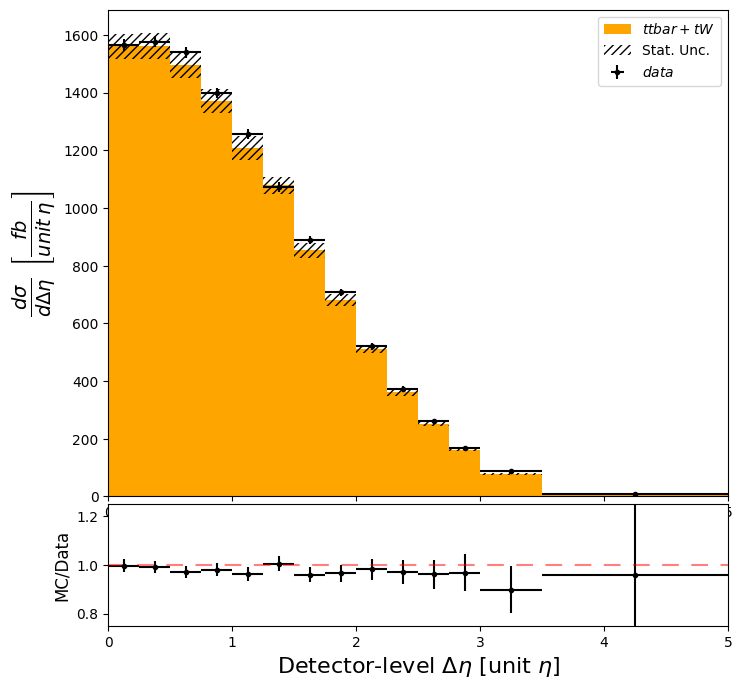

In [ ]:
detector_level_cross_sec('deta')

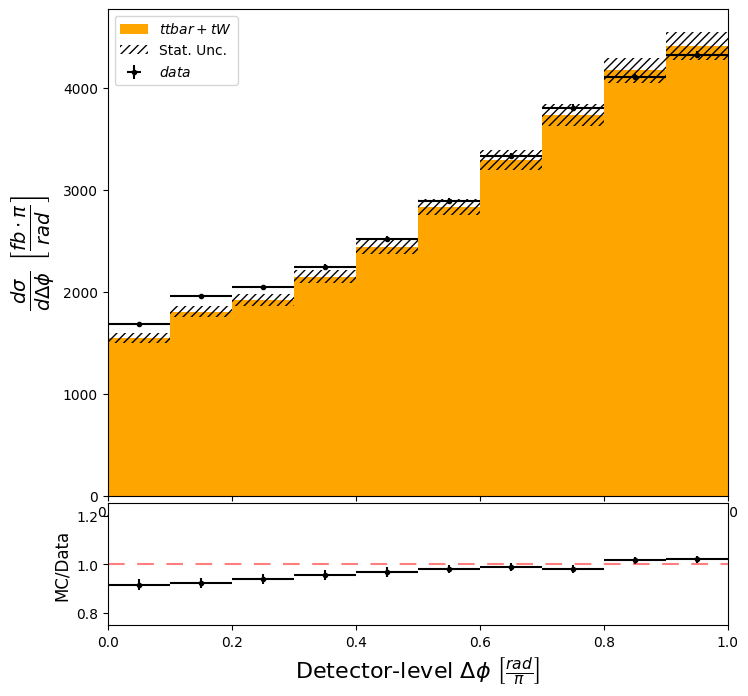

In [ ]:
detector_level_cross_sec('dphi')

**Migration Matrix Construction:**

This function constructs a **migration matrix** between the reconstructed and truth-level values of a chosen kinematic observable, and visualizes it as a 2D color-coded histogram. Such matrices are essential in unfolding procedures, as they describe the detector response and how events migrate between bins due to reconstruction effects.


In [ ]:
def Migration_Matrix(var):
    # Define binning and scaling based on variable
    if var == 'deta':
        factor = 1
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,
                         2.25, 2.5, 2.75, 3, 3.5, 5])
    else:
        factor = np.pi
        bins = np.linspace(0, 1, 11)

    # Bin centres and widths
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Reco-level and truth-level values
    x = data_all['mc_samples_4'][var] / factor
    y = data_all['mc_samples_4'][f't_{var}'] / factor
    w = data_all['mc_samples_4']['Weight']  # Event weights

    # 2D histogram: rows = reco bins, columns = truth bins
    H, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], weights=w)

    # Normalize each row to get percentage of truth events in each reco bin
    row_sums = H.sum(axis=1, keepdims=True)
    H_percent = np.divide(H, row_sums, where=row_sums != 0) * 100

    # Plot 2D migration matrix
    thresh = 0.0  # Only display values above threshold
    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(xedges, yedges, H_percent.T, cmap='Blues', vmin=0, vmax=100)
    fig.colorbar(pcm, ax=ax, label='Migration [%]')

    # Annotate each bin with percentage value
    for i in range(len(xedges) - 1):
        for j in range(len(yedges) - 1):
            v = H_percent[i, j]
            if v > thresh:
                ax.text((xedges[i] + xedges[i + 1]) / 2,
                        (yedges[j] + yedges[j + 1]) / 2,
                        f'{v:.1f}%', color='red',
                        ha='center', va='center', fontsize=7)

    # Axis labels and title
    ax.set_xlabel(r'reco $\Delta\phi$')
    ax.set_ylabel(r'truth $\Delta\phi$')
    ax.set_title(r'Migration Matrix in $\Delta\eta$ [%]' if var == 'deta'
                 else r'Migration Matrix in $\Delta\varphi$ [%]')
    plt.tight_layout()
    plt.show()

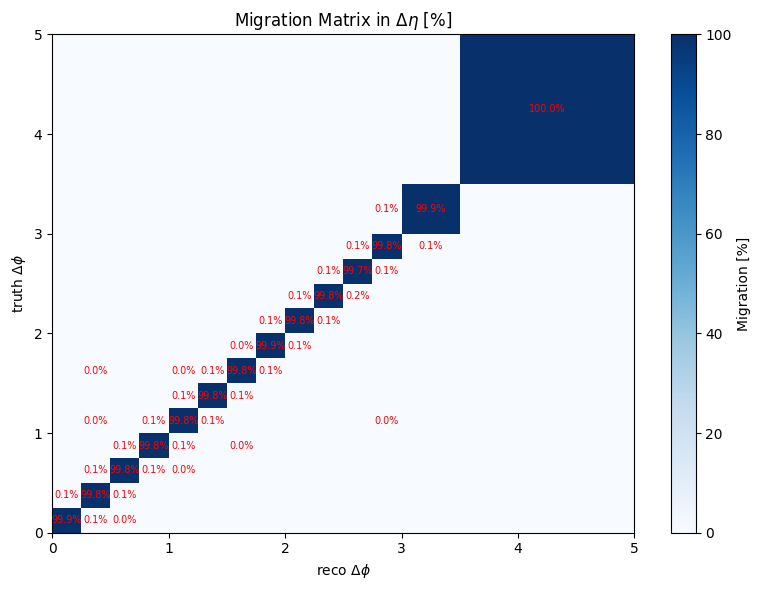

In [ ]:
Migration_Matrix('deta')

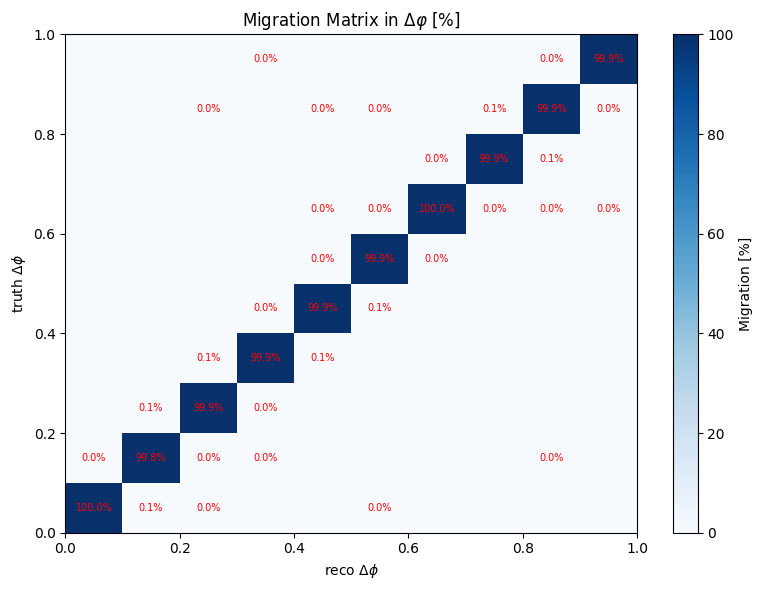

In [ ]:
Migration_Matrix('dphi')

**Factors**

This function calculates and plots the acceptance and efficiency correction factors for a given variable, either $\Delta\phi$ or $\Delta\eta$. The procedure begins by defining the binning and scaling appropriate to the chosen variable. Reconstructed and truth-level histograms are then built for both $t\bar{t}$ and $tW$ simulated samples. From these, the acceptance factor is obtained as the ratio of reconstructed to total generated events, while the efficiency factor is obtained as the ratio of reconstructed to truth-level events. Finally, the function produces a plot showing both factors.

In [ ]:
def factors(var):
    # Define binning, scaling, and axis label depending on the chosen variable
    if var == 'dphi':
        bins = np.linspace(0, 1, 11)  # Uniform Δφ bins from 0 to 1
        factor = np.pi                 # Scale Δφ by π to normalize
        x_name = r'$\Delta\phi$ $\left[\frac{rad}{\pi}\right]$'
    else:
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 5])
        factor = 1                     # No scaling for Δη
        x_name = r'$\Delta\eta$ [unit $\eta$]'

    # Compute bin centres and widths for plotting
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Extract reconstructed (detector-level) and truth-level variables from combined MC
    x = data_all['mc_samples_4'][var] / factor       # Reco-level variable
    y = data_all['mc_samples_4'][f't_{var}'] / factor # Truth-level variable

    # Retrieve corresponding event weights
    w = data_all['mc_samples_4']['Weight']

    # Initialize figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)

    # Histogram of reconstructed-level MC (ttbar + tW)
    MC_counts, _ = np.histogram(data_all['mc_samples_1'][var] / factor,
        bins=bins,weights=data_all['mc_samples_1']['Weight'])

    # Histogram of truth-level MC (ttbar + tW)
    th_counts, _ = np.histogram(data_all['mc_samples_3'][f't_{var}'] / factor,
        bins=bins,weights=data_all['mc_samples_3']['Weight'])

    # Histogram including both reco + truth (for acceptance/efficiency)
    bt_counts, _ = np.histogram(data_all['mc_samples_4'][var] / factor,
        bins=bins,weights=data_all['mc_samples_4']['Weight'])

    # Initialize lists for acceptance and efficiency factors
    facc = []  # Acceptance = reconstructed / total MC
    eff = []   # Efficiency = reconstructed / truth-level MC

    # Compute acceptance and efficiency per bin
    for i in range(len(bt_counts)):
        facc.append(bt_counts[i] / MC_counts[i])
        eff.append(bt_counts[i] / th_counts[i])

    # Plot acceptance and efficiency
    ax.errorbar(bin_centres, facc, xerr=step / 2, fmt='.', color='green', label=r'$Acceptance$')
    ax.errorbar(bin_centres, eff, xerr=step / 2, fmt='.', color='blue', label=r'$Efficiency$')

    # Axis labels and plot formatting
    ax.set_xlabel(x_name, fontsize=16)
    ax.set_xlim(bins[0], bins[-1])
    ax.legend()
    plt.show()


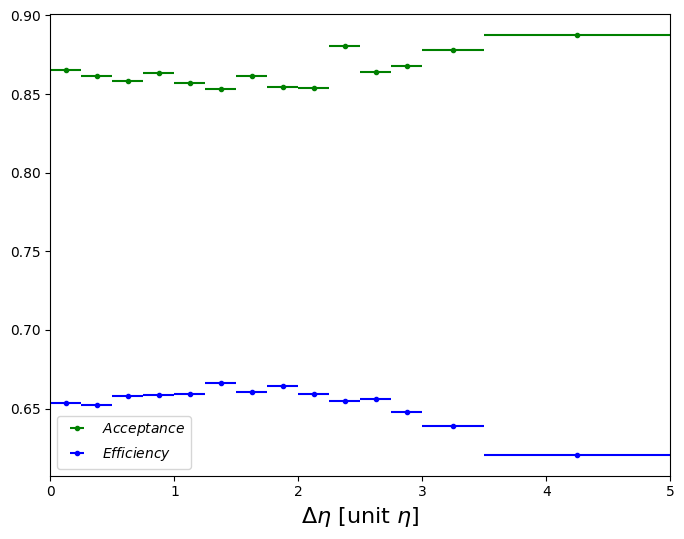

In [ ]:
factors('deta')

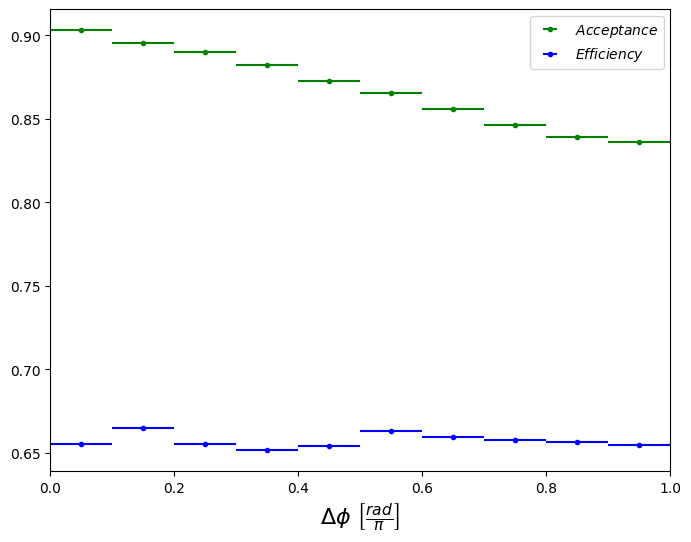

In [ ]:
factors('dphi')

**Closure Test**

This function checks the unfolding procedure by comparing unfolded reconstructed $t\bar{t}$ distributions to the truth-level ones. It builds a migration matrix from simulation, inverts it to unfold reconstructed data, and applies acceptance/efficiency corrections. The unfolded result is plotted against the true distribution, with a lower panel showing the MC/Unfolded ratio for validation.

In [ ]:
def Closure_test(var):
    # Define binning, scaling factor, and axis labels depending on the chosen variable
    if var == 'dphi':
        bins = np.linspace(0, 1, 11)  # Uniform Δφ bins from 0 to 1
        factor = np.pi                 # Scale Δφ by π to normalize
        x_name = r'Particle-level $\Delta\phi$ $\left[\frac{rad}{\pi}\right]$'
        y_name = r'$\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{fb\cdot\pi}{rad}\right]$'
    else:
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 5])
        factor = 1                     # No scaling for Δη
        x_name = r'Particle-level $\Delta\eta$ [unit $\eta$]'
        y_name = r'$\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{fb}{unit\:\eta}\right]$'

    # Compute bin centres and widths
    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # Extract reco-level and truth-level variables from combined MC
    x = data_all['mc_samples_4'][var] / factor
    y = data_all['mc_samples_4'][f't_{var}'] / factor
    w = data_all['mc_samples_4']['Weight']  # Event weights

    # Build 2D histogram (reco vs truth) to create migration matrix
    H, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], weights=w)

    # Normalize each row to obtain percentage migration matrix
    row_sums = H.sum(axis=1, keepdims=True)
    H_percent = np.divide(H, row_sums, where=row_sums != 0) * 100

    # Convert percentages to fractions
    M = H_percent / 100.0

    # Invert the migration matrix; if singular, use pseudo-inverse
    try:
        M_inv = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        M_inv = np.linalg.pinv(M)

    # Create figure with two stacked subplots (upper: distributions, lower: ratio)
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.025)
    ax = fig.add_subplot(gs[0])
    residual_axes = fig.add_subplot(gs[1], sharex=ax)

    # Histogram data and MC samples
    data_counts, _ = np.histogram(data_all['data'][var] / factor, bins=bins)

    MC_counts, _ = np.histogram(data_all['mc_samples_1'][var] / factor,
       bins=bins, weights=data_all['mc_samples_1']['Weight'])

    sys_counts, _ = np.histogram(data_all['mc_samples_2'][var] / factor,
       bins=bins, weights=data_all['mc_samples_2']['Weight'])

    th_counts, _ = np.histogram(data_all['mc_samples_3'][f't_{var}'] / factor,
       bins=bins, weights=data_all['mc_samples_3']['Weight'])

    bt_counts, _ = np.histogram(data_all['mc_samples_4'][var] / factor,
       bins=bins, weights=data_all['mc_samples_4']['Weight'])

    # Initialize unfolded data array
    un_data = []

    # Apply unfolding per bin using the inverse migration matrix
    for i in range(len(M_inv)):
        facc = bt_counts[i] / MC_counts[i]  # Acceptance factor
        eff = bt_counts[i] / th_counts[i]   # Efficiency factor
        Sum = np.sum(facc * M_inv[i] * (MC_counts[i])) / (eff * 36 * step[i])
        un_data.append(Sum)

    un_data = np.array(un_data)
    err_data = np.sqrt(un_data)  # Statistical error on unfolded data

    # Truth-level normalized differential cross-section
    ttbar = th_counts / (36 * step)
    err_MC = np.sqrt(ttbar)

    # Upper plot: truth vs unfolded reco
    ax.bar(bin_centres, ttbar, width=step, color='orange', label=r'$truth\:ttbar$')
    ax.errorbar(bin_centres, un_data, xerr=step / 2, yerr=err_data / 2,
                fmt='.', color='black', label=r'$reco\:unfolded\:ttbar$')

    # Formatting upper plot
    ax.set_ylabel(y_name, fontsize=20)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(bottom=0)
    ax.legend()

    # Lower plot: MC/Data ratio
    ratio = ttbar / un_data
    ratio_err = ratio * err_data / un_data
    residual_axes.errorbar(bin_centres, ratio, fmt='k.')
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data', fontsize=12)
    residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)

    # Show final plot
    plt.show()


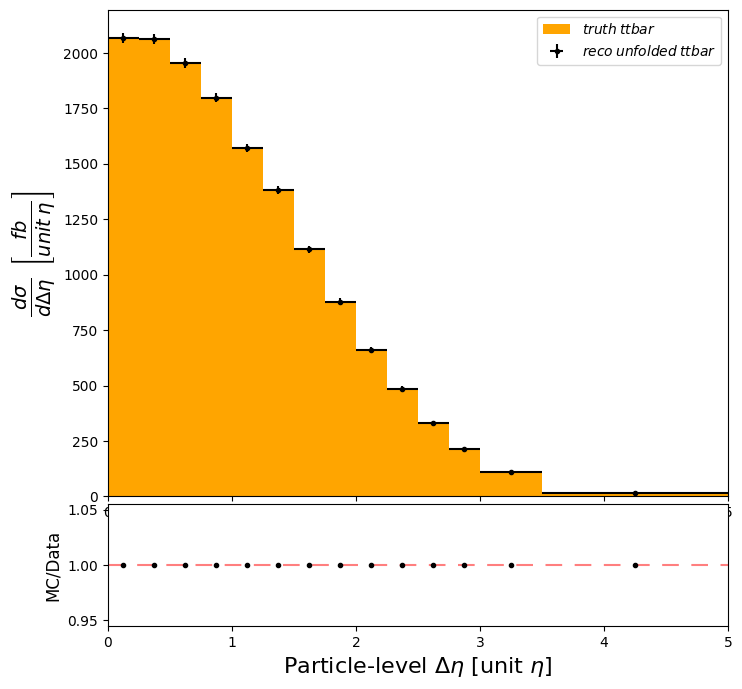

In [ ]:
Closure_test('deta')

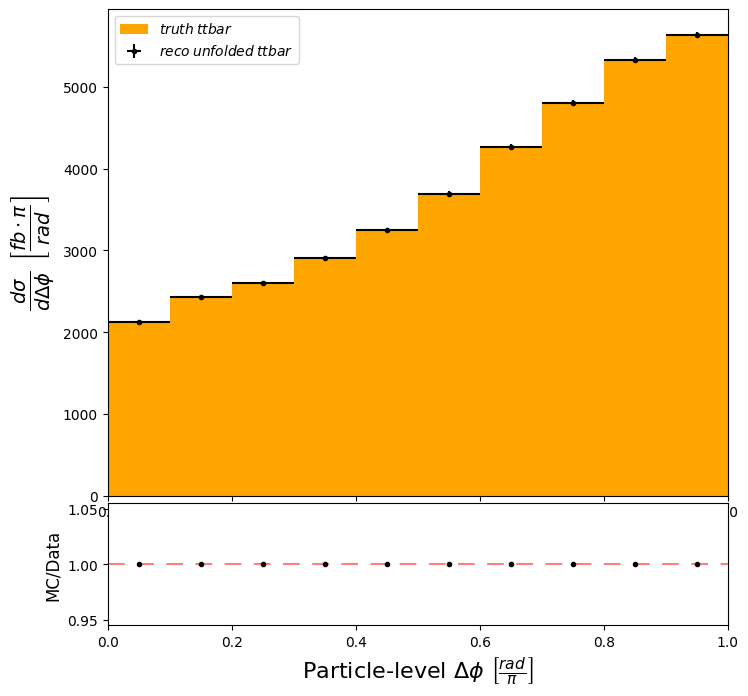

In [ ]:
Closure_test('dphi')

**Statistical Inference with pyhf**

This helper function fits a signal + background model to observed counts using pyhf, extracting the best-fit signal strength $\hat{\mu}$ and computing the CLs    $p$-value for $\mu=1$. It defines a single-channel model with a normfactor modifier for the signal, performs a maximum-likelihood fit, and runs a hypothesis test with the "qtilde" statistic. Returns [$\hat{\mu},p$].

In [ ]:
def run_pyhf_inference(obs_counts, background_counts, signal_counts, var, norm):
    # Set backend
    pyhf.set_backend("numpy")

    # Convert to lists
    obs = obs_counts.tolist()
    bkg = background_counts.tolist()
    sig = signal_counts.tolist()

    if norm:
      which = 'Norm'
    else: which = 'Reg'

    background_modifiers = [
    {"name": "MatrixElement", "type": "shapesys", "data": SYS[var][which]['ME']},
    {"name": "PartonPDF", "type": "shapesys", "data": SYS[var][which]['PDF']},
    {"name": "PartonShower", "type": "shapesys", "data": SYS[var][which]['PSH']},
    {"name": "RadScale", "type": "shapesys", "data": SYS[var][which]['RSS']},
    {"name": "BackgroundModel", "type": "shapesys", "data": SYS[var][which]['BM']},
    {"name": "Pileup", "type": "shapesys", "data": SYS[var][which]['PE']},
    {"name": "Luminosity", "type": "shapesys", "data": SYS[var][which]['L']},
    {"name": "LeptonReco", "type": "shapesys", "data": SYS[var][which]['LIR']},
    {"name": "JetReco", "type": "shapesys", "data": SYS[var][which]['JIR']},
    {"name": "btagging", "type": "shapesys", "data": SYS[var][which]['BT']},
    {"name": "MCstat", "type": "shapesys", "data": SYS[var][which]['MCSU']}]

    # Model specification
    model_spec = {
        "channels": [
            {
                "name": "main",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig,
                        "modifiers": [{"name": "mu", "type": "normfactor", "data": None}]
                    },
                    {
                  "name": "background",
                  "data": bkg,
                  "modifiers": background_modifiers
                    }
                ]
            }
        ]
    }

    # Build model and get data
    model = pyhf.Model(model_spec)
    data = obs + model.config.auxdata

    # Get best fit μ
    fit_result = pyhf.infer.mle.fit(data, model)
    mu_hat = fit_result[model.config.poi_index]

    # Hypothesis test: μ = 1 (i.e., Standard Model signal)
    # Returns CLs value = p-value-like quantity
    CLs_obs = pyhf.infer.hypotest(
        poi_test=1.0,
        data=data,
        pdf=model,
        test_stat="qtilde",
        return_expected=False
    )

    # CLs_obs is a 1-element array: [p_value]
    p_value = float(CLs_obs)
    return [mu_hat, p_value]

**Unfolding and Comparison with Data**

This function performs one-dimensional unfolding for angular observables ($\Delta\eta$ or $\Delta\phi$), aiming to correct detector effects and compare particle-level predictions to measured data.


* **Migration Matrix Construction:**
Built using simulation, mapping truth-level to reconstructed values. Inverted to unfold the reco-level distribution.

* **Efficiency & Acceptance Corrections:**
Applied bin-by-bin using simulated matched events to ensure detector acceptance and selection efficiency are accounted for.

* **Unfolded Results:**
Unfolded $t\bar{t}$ and $tW$ distributions are shown stacked. Statistical and systematic uncertainties are displayed.

* **Validation Plot:**
Includes a bottom panel with the MC/Data ratio and uncertainty bands for quality assessment.


In [ ]:
def cross_section(var, norm):
    # --------------------------
    # 1. Binning & axis labels
    # --------------------------
    if var == 'dphi':
        # Equal binning from 0 to 1 for Δφ, scaled by π
        bins = np.linspace(0, 1, 11)
        factor = np.pi
        x_name = r'Particle-level $\Delta\phi$ $\left[\frac{rad}{\pi}\right]$'

        # y-axis label depends on normalisation choice
        if norm:
            y_name = r'$\frac{1}{\sigma}\cdot\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{\pi}{rad}\right]$'
        else:
            y_name = r'$\frac{d\sigma}{d\Delta\phi}$ $\left[\frac{fb\cdot\pi}{rad}\right]$'

    else:
        # Custom binning for Δη
        bins = np.array([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,
                         2.25, 2.5, 2.75, 3, 3.5, 5])
        factor = 1
        x_name = r'Particle-level $\Delta\eta$ [unit $\eta$]'

        if norm:
            y_name = r'$\frac{1}{\sigma}\cdot\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{1}{unit\:\eta}\right]$'
        else:
            y_name = r'$\frac{d\sigma}{d\Delta\eta}$ $\left[\frac{fb}{unit\:\eta}\right]$'

    # -----------------------------------
    # 2. Build migration matrix (reco→truth)
    # -----------------------------------
    # Reconstructed observable from both ttbar and tW
    x = data_all['mc_samples_4'][var] / factor
    # Truth observable from both ttbar and tW
    y = data_all['mc_samples_4'][f't_{var}'] / factor
    # Event weights
    w = data_all['mc_samples_4']['Weight']

    bin_centres = (bins[:-1] + bins[1:]) / 2
    step = bins[1:] - bins[:-1]

    # 2D histogram of reco vs truth with weights
    H, xedges, yedges = np.histogram2d(x, y, bins=[bins, bins], weights=w)

    # Row-normalise to percentage
    row_sums = H.sum(axis=1, keepdims=True)
    H_percent = np.divide(H, row_sums, where=row_sums != 0) * 100

    # Convert % to fraction for migration matrix M
    M = H_percent / 100.0

    # Invert migration matrix (pseudo-inverse if singular)
    try:
        M_inv = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        M_inv = np.linalg.pinv(M)

    # --------------------------
    # 3. Set up figure layout
    # --------------------------
    fig = plt.figure(figsize=(8, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.025)
    ax = fig.add_subplot(gs[0])
    residual_axes = fig.add_subplot(gs[1], sharex=ax)

    # --------------------------
    # 4. Histogram counts
    # --------------------------
    # Data counts (reco-level)   data_all['mc_samples_4'][var]
    data_counts, _ = np.histogram(data_all['data'][var] / factor, bins=bins)

    # MC reco-level
    MC_counts,_ = np.histogram(data_all['mc_samples_1'][var] / factor,
        bins=bins, weights=data_all['mc_samples_1']['Weight'])

    # sys MC
    sys_counts, _ = np.histogram(data_all['mc_samples_2'][var] / factor,
        bins=bins, weights=data_all['mc_samples_2']['Weight'])

    # MC truth-level
    th_counts,_ = np.histogram(data_all['mc_samples_3'][f't_{var}'] / factor,
        bins=bins, weights=data_all['mc_samples_3']['Weight'])

    # MC both (combined reco)
    bt_counts,_ = np.histogram(data_all['mc_samples_4'][var] / factor,
        bins=bins, weights=data_all['mc_samples_4']['Weight'])

    # SUSY signal truth-level histograms
    stop_counts,_ = np.histogram(data_all['mc_samples_5'][f't_{var}'] / factor,
        bins=bins, weights=data_all['mc_samples_5']['Weight'])

    stop_390420_counts,_ = np.histogram(data_all['mc_samples_5'][f't_{var}'] / factor,
        bins=bins, weights=data_all['mc_samples_5']['Weight'])
    stop_390447_counts,_ = np.histogram(data_all['mc_samples_6'][f't_{var}'] / factor,
        bins=bins, weights=data_all['mc_samples_6']['Weight'])
    stop_391833_counts,_ = np.histogram(data_all['mc_samples_7'][f't_{var}'] / factor,
        bins=bins, weights=data_all['mc_samples_7']['Weight'])

    un_data = []  # unfolded data values

    # --------------------------
    # 5. Normalisation factors
    # --------------------------
    if norm:
        data_factor = np.sum(data_counts)
        MC_factor = np.sum(MC_counts)
        SUSY_factor_390420 = np.sum(stop_390420_counts)
        SUSY_factor_390447 = np.sum(stop_390447_counts)
        SUSY_factor_391833 = np.sum(stop_391833_counts)
    else:
        # 36 fb⁻¹ fixed luminosity scaling
        data_factor = 36
        MC_factor = 36
        SUSY_factor_390420 = 36
        SUSY_factor_390447 = 36
        SUSY_factor_391833 = 36

    # --------------------------
    # 6. Unfolding
    # --------------------------
    for i in range(len(M_inv)):
        facc = (bt_counts[i]) / (MC_counts[i])  # acceptance
        eff = (bt_counts[i]) / (th_counts[i])  # efficiency

        # Unfolded value = sum over migration matrix inversion applied to data counts
        Sum = np.sum(facc * M_inv[i] * (data_counts[i])) / (eff * data_factor * step[i])
        un_data.append(Sum)

    un_data = np.array(un_data)

    # --------------------------
    # 7. Statistical errors
    # --------------------------
    if norm:
        err_data = np.sqrt(data_counts) / (data_factor * step)
    else:
        err_data = np.sqrt(un_data)

    # MC truth-level cross sections
    th_MC = np.array(th_counts / (MC_factor * step))

    sys_counts = np.array(sys_counts / (MC_factor * step))

    # SUSY signal normalised cross sections
    stop_390420_sin = np.array(stop_390420_counts / (SUSY_factor_390420 * step))
    stop_390447_sin = np.array(stop_390447_counts / (SUSY_factor_390447 * step))
    stop_391833_sin = np.array(stop_391833_counts / (SUSY_factor_391833 * step))

    height = th_MC  # total SM MC prediction

    if var == 'dphi':
      if norm:
        SYS_STAT =  np.array([1.75, 0.78, 1.85, 1.02, 0.61, 1.1,  0.49, 0.47, 0.73, 0.87])
      else: SYS_STAT =  np.array([6.29, 5.9, 5.95, 5.81, 5.88, 5.56, 6.0, 5.95, 6.05, 6.06])
    else:
      if norm:
        SYS_STAT =  np.array([5.61, 5.78, 6.25, 5.98, 6.98, 5.52, 6.11, 5.92, 5.74, 6.14, 6.23, 6.5, 6.56, 8.49])
      else: SYS_STAT =  np.array([1.07, 0.6, 0.76, 0.77, 1.84, 1.12, 0.88, 1.0, 1.4, 1.83, 1.94, 2.53, 3.58, 5.28])

    err_MC  = th_MC * SYS_STAT *1e-2
    sys_counts = (th_MC - sys_counts) / th_MC  # systematics from alt MC
    # --------------------------
    # 8. Upper plot (stacked MC + signals)
    # --------------------------
    #ax.bar(bin_centres, tW, width=step, color='cyan', label=r'$tW$', alpha=1)
    #ax.bar(bin_centres, ttbar, width=step, color='orange', label=r'$ttbar$', alpha=1, bottom=tW)
    ax.bar(bin_centres, th_MC, width=step, color='orange', label=r'$t\bar{t}\:+\:tW$', alpha=1)

    ax.bar(bin_centres, err_MC, alpha=0.5, bottom=height - err_MC / 2,
           color='none', hatch="////", width=step, label='Sys & Stat Unc')

    # If normalised, run pyhf for SUSY signal strength & p-values
    if norm:

        for stop_counts, stop_id, stop_color in [
            (stop_390420_sin, 390420, 'blue'),
            (stop_390447_sin, 390447, 'green'),
            (stop_391833_sin, 391833, 'purple')
        ]:
            y_err = stop_counts * 0.045
            mu_value, p_value = run_pyhf_inference(un_data, height, stop_counts, var, norm)
            label = rf"$\tilde{{t}}\tilde{{\bar{{t}}}}\ {stop_id}\ \text{{best fit }}\hat{{\mu}} = {mu_value:.2f}\:\text{{and}}\:\text{{p}} = {p_value:.2f} $"
            ax.errorbar(bin_centres, stop_counts, color=stop_color, label=label, alpha=0.5,yerr=y_err, xerr=step/2,linestyle="None")

    # Overlay unfolded data points
    ax.errorbar(bin_centres, un_data, xerr=step / 2, yerr=err_data / 2,
                fmt='.', color='black', label=r'$Data$')

    # Axis settings
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data')
    ax.set_ylabel(y_name, fontsize=20)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(bottom=0)
    ax.legend()

    # --------------------------
    # 9. Lower plot (MC/Data ratio)
    # --------------------------
    ratio = height / un_data
    ratio_err = ratio * err_data / un_data

    sys_stat = (err_MC / np.sum(height) + sys_counts)  # combined sys + stat band
    bot = (1 - sys_stat / 2)

    residual_axes.bar(bin_centres, sys_stat, bottom=bot, width=step, color='gray', alpha=0.5, label="sys + sta")
    residual_axes.errorbar(bin_centres, ratio, yerr=ratio_err, xerr=step / 2, fmt='k.')
    residual_axes.set_xlabel(x_name, fontsize=16)
    residual_axes.set_ylabel('MC/Data', fontsize=12)
    residual_axes.axhline(1, color='r', linestyle=(0, (8, 6)), alpha=0.5)
    residual_axes.set_ylim(0.75, 1.25)
    residual_axes.legend()

    # Display plots
    plt.show()
    return


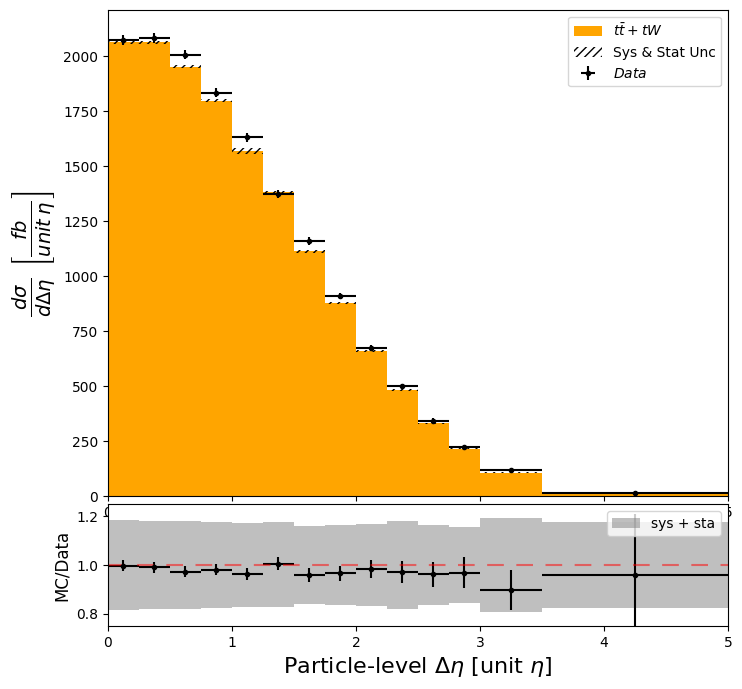

In [ ]:
cross_section('deta',0)

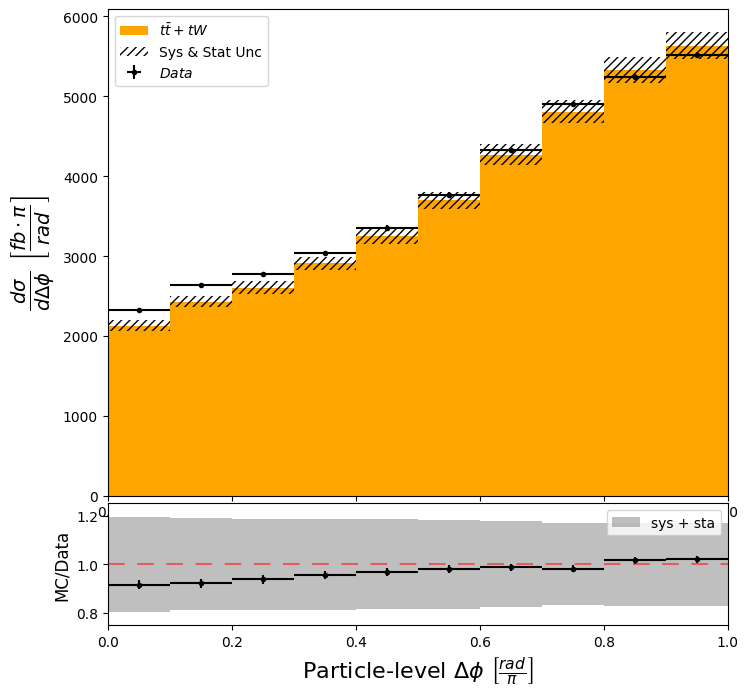

In [ ]:
cross_section('dphi',0)

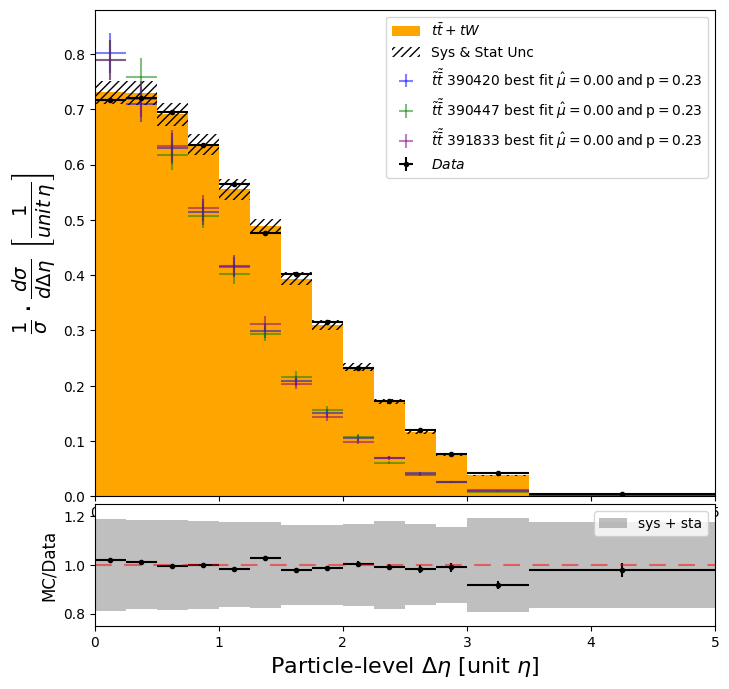

In [ ]:
cross_section('deta',1)

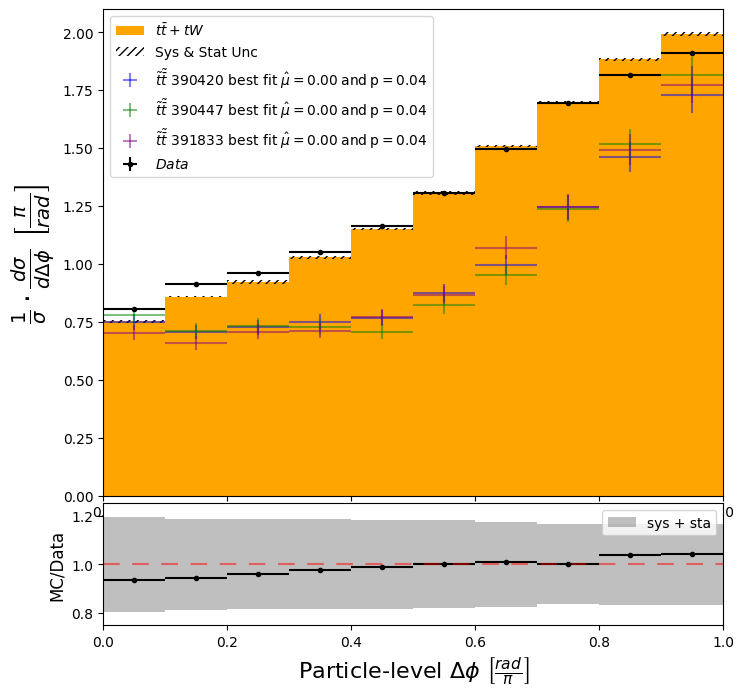

In [ ]:
cross_section('dphi',1)